In [224]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import svm
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2})

In [110]:
def ccn_model(eta_star, alpha, beta):
    return (1 - beta - alpha)*eta_star + alpha

def eta(x, environment):
    if environment=='sinusoid':
        return .5 + .5 * np.sin(2.9*x + .1)
    elif environment=='low_base_rate_sinusoid':
        return np.piecewise(x,[
            ((-1 <= x) & (x <= .28)),
            ((.28< x) & (x <= .71)),
            ((0.71 < x) & (x <= 1))],  
            [lambda v: .5+.5 *np.sin(.4*v -1.28), 
             lambda v: .5 + .5*np.sin(12*v-4.5),
             lambda v: .081+1.9*np.power((v-.7), 2) ])
    else: 
        return np.piecewise(x,[
            ((-1 <= x) & (x <= -.5)),
            ((-.5 < x) & (x <= 0.2069)),
            ((0.2069 < x) & (x <= 0.8)),
            ((0.8 < x) & (x <= 1))],  
            [lambda v: -1.5*v-.75, 
             lambda v: 1.4*v+.7,
             lambda v: -1.5*v+1.3,
             lambda v: 1.25*v - .9 ])
    

def pi(x, func):
    if func=='uniform': 
        pi = np.ones(x.shape)
        
    elif func=='linear': 
        pi = .2*x + .4

    return pi
    
def plot_tcn(eta_star, rand_intervention, show_propensity, show_samples):
    f, axs = plt.subplots(1, 2, sharey=False, figsize=(14,5))
    
    N=200
    
    for d in [0,1]:

        # Apply CCN noise model
        if d == 0:
            alpha_0, beta_0 = .1, .15
            eta_y = ccn_model(eta_star, beta=alpha_0, alpha=beta_0)
        else:
            alpha_1, beta_1 = .2, .05
            eta_y = ccn_model(eta_star, beta=alpha_1, alpha=beta_1)

        #Sample propensity function
        obs_outcome = np.random.binomial(1, pi(x, do=d, uniform=rand_intervention), size=eta_y.size)

        # Sample from proxy counterfactual class probability funcion
        samples_x = x[obs_outcome==1]
        samples_y = np.random.binomial(1, eta_y[obs_outcome==1], size=eta_y[obs_outcome==1].size)
        
        # Class probability functions
        axs[d].plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
        axs[d].plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')

        # Propensity function
        if show_propensity:
            axs[d].plot(x, pi(x, do=d, uniform=rand_intervention), label='$\pi(x)$', color='orange', linestyle='--')

        # Samples
        if show_samples:
            axs[d].scatter(samples_x[samples_y==1], samples_y[samples_y==1], marker='+', color='black', label=f'$Y_{d}=1$')
            axs[d].scatter(samples_x[samples_y==0], samples_y[samples_y==0], marker='o', color='black', label=f'$Y_{d}=0$')

        # Plot grid
        axs[d].set_xticks(np.arange(-1.0, 1.02, .2), fontsize=20)
        axs[d].set_yticks(np.arange(0.0, 1.01, .2), fontsize=20)
        axs[d].grid(which='both')

        # Or if you want different settings for the grids:
        axs[d].grid(which='minor', alpha=0.2)
        axs[d].grid(which='major', alpha=0.5)
        # ax.set_xlim([0, 1])

        axs[d].set_ylabel('Probability', size=14)
        axs[d].set_xlabel('X', size=14)
        axs[d].tick_params(axis='x', labelsize=13)
        axs[d].tick_params(axis='y', labelsize=13)

        if d == 0:
            axs[d].set_title(r'D:=0, CCN($\alpha_0=.1, \beta_0=.15$)', size=14)
            axs[d].legend(prop={'size': 14}, loc='center right')
        else:
            axs[d].set_title(r'D:=1, CCN($\alpha_1=.2, \beta_1=.05$)', size=14)
            axs[d].legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1))        
    return f

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def learn_eta_hat(do, exp_dataset, method='IPW'):

    data = pd.DataFrame(exp_dataset)
    te_ix = int(data.shape[0]*.7)

    train = data.iloc[:te_ix]
    train_x = train['X'][train['Ds']==1].to_numpy().reshape(-1, 1)
    train_y = train['Y'][train['Ds']==1].to_numpy()
    train_dx = train['X'].to_numpy().reshape(-1, 1)
    train_d = train['Ds'].to_numpy()

    val = data.iloc[te_ix:]
    val_x = val['X'][val['Ds']==1].to_numpy().reshape(-1, 1)
    val_y = val['Y'][val['Ds']==1].to_numpy()
    
    clf = MLPClassifier(alpha=0, hidden_layer_sizes=(40, 4))
    clf.fit(train_x, train_y)    
    val_py = clf.predict_proba(val_x)

    return val_x, val_y, val_py
     

### Parameter Estimation Experiment

NameError: name 'error_min' is not defined

In [271]:
plot = True
dataset_sizes = [4000, 4500, 5000, 5500, 6000]

# Experiment setup
NS = 200
N_ITERS = 5
do = 0
xmin, xmax = -1, 1
x = np.linspace(xmin, xmax, num=NS)



def generate_syn_data(
    y0_func='low_base_rate_sinusoid',
    y1_func='sinusoid',
    error_min=0.05,
    error_max=0.25
):
    
    alpha_0, alpha_1, beta_0, beta_1 = random.uniform(error_min, error_max, 4)

    # Define class probability functions
    eta_star_0 = eta(x, environment='low_base_rate_sinusoid')
    eta_star_1 = eta(x, environment='sinusoid')
    eta_y_0 = ccn_model(eta_star_0, alpha_0, beta_0)
    eta_y_1 = ccn_model(eta_star_1, alpha_1, beta_1)

    # Sample from target potential outcome class probability distributions
    YS_0 = np.random.binomial(1, eta_star_0, size=NS)
    YS_1 = np.random.binomial(1, eta_star_1, size=NS)

    # Apply measurement error model
    Y_0 = YS_0.copy()
    Y_0[(YS_0==0) & (np.random.binomial(1, alpha_0, size=NS)==1)] = 1
    Y_0[(YS_0==1) & (np.random.binomial(1, beta_0, size=NS)==1)] = 0

    Y_1 = YS_1.copy()
    Y_1[(YS_1==0) & (np.random.binomial(1, alpha_1, size=NS)==1)] = 1
    Y_1[(YS_1==1) & (np.random.binomial(1, beta_1, size=NS)==1)] = 0

    # Apply consistency to observe potential outcomes
    YS, Y = np.zeros(NS, dtype=np.int64), np.zeros(NS, dtype=np.int64)
    D = np.random.binomial(1, pi(x, func='linear'), size=NS)

    YS[D==0] = YS_0[D==0]
    YS[D==1] = YS_1[D==1]

    Y[D==0] = Y_0[D==0]
    Y[D==1] = Y_1[D==1]

    expdf = pd.DataFrame({
        'X': x,
        'YS_0': YS_0,
        'YS_1': YS_1,
        'Y_0': Y_0,
        'Y_1': Y_1,
        'D': D,
        'YS': YS,
        'Y': Y
    })
    
    expdf = expdf.sample(frac=1).reset_index(drop=True)
    
    errors = {
        alpha_0: alpha_0,
        alpha_1: alpha_1, 
        beta_0: beta_0, 
        beta_1: beta_1
    }
    
    return expdf, errors

##################################
####  End the data generating process
##################################

train_ratio = .7
split_ix = int(NS*train_ratio)

train_df = expdf.iloc[:split_ix,:]
val_df = expdf.iloc[split_ix:,:]

do=1

# Outcome models
models = ['Y', 'YD', f'Y_{do}', f'YS_{do}']
exp_results = dict.fromkeys(models, [])

for model in models:
    clf = MLPClassifier(alpha=0, hidden_layer_sizes=(40, 4))
    

    if model == 'YD':
        train = train_df[train_df['D'] == do]
        target = 'Y'
    else:
        train = train_df
        target = model

    clf.fit(train['X'].to_numpy().reshape(-1, 1), train[target])
    pyhat = clf.predict_proba(val_df['X'].to_numpy().reshape(-1, 1))
    auroc = roc_auc_score(val_df[target], pyhat[:, 1])
    
    exp_results[model].append(auroc)
    
pd.DataFrame(exp_results)




,Y,YD,Y_1,YS_1
0,0.743590,0.743590,0.743590,0.743590
1,0.672772,0.672772,0.672772,0.672772
2,0.802455,0.802455,0.802455,0.802455
3,0.775670,0.775670,0.775670,0.775670


{'Y': [], 'YD': [], 'Y_1': [], 'YS_1': []}

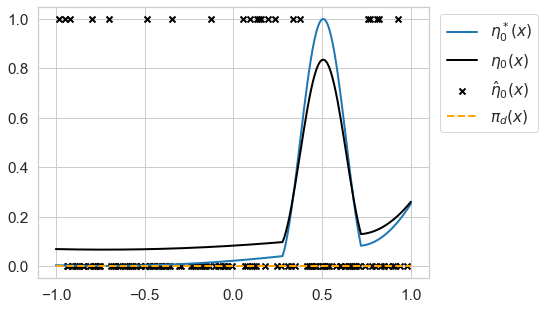

In [233]:
f, axs = plt.subplots(1, 1, sharey=False, figsize=(7,5))

# Class probability functions
axs.plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
axs.plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')
axs.scatter(x[x_s], y_s, marker='x', color='black', label=f'$\hat \eta_0(x)$')
axs.plot(x, p, label='$\pi_d(x)$', color='orange', linestyle='--')
plt.legend(bbox_to_anchor=(1.3, 1))





In [39]:
# Experiment setup
N_SAMPLES = 200
N_ITERS = 5

# Configuration
plot=True
environment='low_base_rate_sinusoid'
dataset_sizes = [4000, 4500, 5000, 5500, 6000]

# Experiment setup
xmin, xmax = -1, 1
x = np.linspace(xmin, xmax, num=200)
eta_star = eta(x, environment=environment)
do=0



runs = {
    'N': [],
    'alpha': [],
    'alpha_hat': [],
    'beta': [],
    'beta_hat': [], 
    'alpha_error': [], 
    'beta_error': [],
    'total_error': [],
    'method': []
}

for N in dataset_sizes:
    for run in range(15):
        alpha = random.uniform(.05, .2)
        beta =  random.uniform(.05, .2)

        # Sample data
        xs = np.random.uniform(xmin, xmax, size=N)
        ds = np.random.binomial(1, pi(xs, do=0, environment=environment)) #make do() instead of draw
        etass = eta(xs, environment=environment)
        eta_y = ccn_model(eta_star, beta=beta, alpha=alpha)
        pysd = ccn_model(etass, beta=beta, alpha=alpha)
        yobs = np.random.binomial(1, pysd)

        exp_dataset = {
            'X': xs,
            'Y': yobs,
            'Yps': yobs,
            'Ds': ds,
        }
        
        val_x, val_y, val_py, val_pd = learn_eta_hat(do=0, exp_dataset=exp_dataset, method='ce')
        
        # Compute estimates and errors
        pix = pi(val_x, do=d, environment=environment)
        ix_min = val_py[:, 1].argmin()
        ix_max = val_py[:, 1].argmax()


        alpha_hat = val_py[ix_min, 1]
        beta_hat = 1 - val_py[ix_max, 1]

        alpha_error = np.abs(alpha_hat-alpha)
        beta_error = np.abs(beta_hat-beta)
        total_error = alpha_error+beta_error

        # Track error statistics
        runs['N'].append(N)
        runs['alpha'].append(alpha)
        runs['beta'].append(beta)
        runs['alpha_hat'].append(alpha_hat)
        runs['beta_hat'].append(alpha_hat)
        runs['alpha_error'].append(alpha_error)
        runs['beta_error'].append(beta_error)
        runs['total_error'].append(total_error)
        runs['method'].append(method)

        if run==0 and plot:
            f, axs = plt.subplots(1, 1, sharey=False, figsize=(7,5))

            # Class probability functions
            axs.plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
            axs.plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')
            axs.scatter(val_x, val_py[:,1], marker='x', color='black', label=f'$\hat \eta_0(x)$')

            # Propensity function
            pix = pi(x, do=0, environment=environment)
            axs.plot(x, pix.squeeze(), label='$\pi_d(x)$', color='orange', linestyle='--')
            axs.scatter(val_x, val_pd[:,1], marker='x',  color='orange', label=f'$\hat \pi_d(x)$')


            plt.title(f'method={method}, do(D={d}), N={N}, eta_min={val_py[ix_min, 1]}', )
            plt.legend(bbox_to_anchor=(1.4, 1))


TypeError: pi() got an unexpected keyword argument 'do'

## Error Parameter Plot

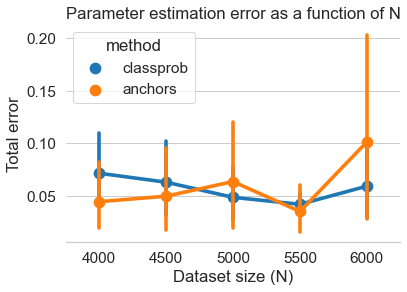

In [10]:
runslog = pd.DataFrame(runs)
data = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['alpha_error', 'beta_error'], value_name='error')

data = data[data['variable'] == 'alpha_error']
sns.pointplot(data=data, x='N', y='error', hue='method')
plt.ylabel('Total error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)



In [8]:
pd.DataFrame(runs)

,N,alpha,alpha_hat,beta,beta_hat,alpha_error,beta_error,total_error,method
0,4000,0.117061,0.067349,0.162436,0.067349,0.049712,0.428642,0.478354,classprob
1,4000,0.117061,0.112535,0.162436,0.112535,0.004526,0.435775,0.440301,anchors
2,4000,0.109253,0.047102,0.086974,0.047102,0.062151,0.483404,0.545555,classprob
3,4000,0.109253,0.055176,0.086974,0.055176,0.054077,0.500718,0.554795,anchors
4,4000,0.135748,0.087177,0.138956,0.087177,0.048572,0.318571,0.367143,classprob
...,...,...,...,...,...,...,...,...,...
145,6000,0.056068,0.018319,0.186583,0.018319,0.037749,0.089170,0.126920,anchors
146,6000,0.101382,0.086612,0.197139,0.086612,0.014770,0.083493,0.098263,classprob
147,6000,0.101382,0.108363,0.197139,0.108363,0.006981,0.084856,0.091837,anchors
148,6000,0.125923,0.104181,0.151828,0.104181,0.021741,0.010469,0.032210,classprob
